In [ ]:
# Importing modules
import torch as to
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch.utils.data as to_data
import datetime as datetime
from torch.utils.tensorboard import SummaryWriter as sumwriter
import os as os

In [ ]:
# Specify hardware for ML training (GPU default)
device = "cuda" if to.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
# Quickly generate list of strings for frequency numbers and ratios
def freq_name(no_freq, include_freq=True, include_ratio=True):
    """
    Creates an ordered list of string from inputted parameters:

    no_freq = (int) number of desired frequencies
    include_freq = (bool) include the individual frequencies or not (default True)
    include_ratio = (bool) include the non-trivial ratios between frequencies or not (default True)
    """
    names = []
    if include_freq:
        for i in range(no_freq):
            names.append('f'+str(i+1))
    if include_ratio:
        for i in range(no_freq):
            for j in range(i):
                names.append('f'+str(i+1)+'/f'+str(j+1))
    return names

def get_modecols(mode_num, divs=8):
    names = []
    for i in range(81):
        names.append('m'+str(mode_num)+'_'+str(i+1))
    names = np.array(names).reshape((9,9))
    it = int(8/divs)
    return list(names[::it, ::it].flatten())

In [ ]:
def activation(activ_name):
    if activ_name=='relu':
        return to.nn.ReLU()
    elif activ_name=='lrelu':
        return to.nn.LeakyReLU()
    elif activ_name=='prelu':
        return to.nn.PReLU()
    elif activ_name=='relu6':
        return to.nn.ReLU6()
    elif activ_name=='sigmoid':
        return to.nn.Sigmoid()
    elif activ_name=='tanh':
        return to.nn.Tanh()
    elif activ_name=='silu':
        return to.nn.SiLU()
    elif activ_name=='selu':
        return to.nn.SELU()
    elif activ_name=='celu':
        return to.nn.CELU()
    elif activ_name=='gelu':
        return to.nn.GELU()
    else:
        return to.nn.ReLU()

In [ ]:
class AE_data(to_data.Dataset):
    def __init__(self, scaled_dataframe, X_names, Y_names):
        self.len = len(scaled_dataframe)
        self.X = to.from_numpy(scaled_dataframe[X_names].to_numpy().astype('float32')).to(device)
        self.Y = to.from_numpy(scaled_dataframe[Y_names].to_numpy().astype('float32')).to(device)

    def __len__(self):
        return self.len
  
    def __getitem__(self, idx):
        X_idx = self.X[idx,:]
        Y_idx = self.Y[idx,:]
        return X_idx, Y_idx

In [ ]:
class AE_Network(to.nn.Module):
    def __init__(self, num_X, num_Z, he_nodes, hd_nodes, hactiv_type):
        super(AE_Network, self).__init__()

        self.esec = []
        self.esec.append(to.nn.Linear(num_X, he_nodes[0]))
        self.esec.append(activation(hactiv_type))

        for i in range(len(he_nodes)-1):
            self.esec.append(to.nn.Linear(he_nodes[i], he_nodes[i+1]))
            self.esec.append(activation(hactiv_type))

        self.esec.append(to.nn.Linear(he_nodes[-1], num_Z))

        self.esec = to.nn.Sequential(*self.esec).to(device)
        for i in self.esec[::2]:
            to.nn.init.kaiming_uniform_(i.weight)
            to.nn.init.zeros_(i.bias)

        self.dsec = []
        self.dsec.append(to.nn.Linear(num_Z, hd_nodes[0]))
        self.dsec.append(activation(hactiv_type))

        for i in range(len(hd_nodes)-1):
            self.dsec.append(to.nn.Linear(hd_nodes[i], hd_nodes[i+1]))
            self.dsec.append(activation(hactiv_type))

        self.dsec.append(to.nn.Linear(hd_nodes[-1], num_X))
        
        self.dsec = to.nn.Sequential(*self.dsec).to(device)
        for i in self.dsec[::2]:
            to.nn.init.kaiming_uniform_(i.weight)
            to.nn.init.zeros_(i.bias)

    def encode(self, X):
        Z = self.esec(X)
        return Z
    
    def decode(self, Z):
        Xp = self.dsec(Z)
        return Xp

    def forward(self, X):
        Z = self.encode(X)
        Xp = self.decode(Z)
        return Xp, Z

In [ ]:
def train_epoch(
    network,
    train_dataloader,
    loss_function, optimizer,
    tb_writer, epoch_ind
    ):

    loss_list = []

    for i, data in enumerate(train_dataloader):
        X, Y = data

        if epoch_ind==0 and i==0:
            tb_writer.add_graph(network, X, verbose=False)

        optimizer.zero_grad()
        Xp, Z = network(X)
        loss = loss_function(Xp, X) 
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()
    
    mean_loss = to.mean(to.tensor(loss_list, device=device)).item()

    return mean_loss

def valid_epoch(
    network,
    valid_dataloader,
    loss_function
    ):

    loss_list = []

    for i, data in enumerate(valid_dataloader):
        X, Y = data
        Xp, Z = network(X)
        loss = loss_function(Xp, X) 
        loss_list.append(loss.item())
        
    mean_loss = to.mean(to.tensor(loss_list, device=device)).item()

    return mean_loss

In [ ]:
def train_AE(
    network,
    train_dataloader, valid_dataloader,
    loss_function, optimizer_type,
    epochs, learn_rate
    ):

    if optimizer_type=='adam':
        optimizer = to.optim.Adam(network.parameters(), lr=learn_rate)
    else:
        optimizer = to.optim.SGD(network.parameters(), lr=learn_rate)
    
    tb_writer = sumwriter('Current_ML_Results/Tensorboard/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    for i in range(epochs):
        network.train(True)
        mloss = train_epoch(network, train_dataloader, loss_function, optimizer, tb_writer, i)

        network.eval()
        with to.no_grad():
            vmloss = valid_epoch(network, valid_dataloader, loss_function)
        
        print('-'*50)
        print('Epoch {} / {}'.format(i+1,epochs))
        print('-'*15)
        print('Average Train Loss : {}'.format(mloss))
        print('Average Validation Loss : {}'.format(vmloss))

        tb_writer.add_scalars("Batch Mean Loss",
                            {
                                'Train' : mloss,
                                'Validation' : vmloss
                            }, i+1)
                            
    tb_writer.flush()
    tb_writer.close()

In [ ]:
# Prepare Data
import sklearn.preprocessing as sk_preproc
data = pd.read_csv('Data Workspace\FS_TV.csv')
num_freq = 10

X_names = freq_name(num_freq,1,1)
Y_names = ['nu', 'a/b', 'a/h', 'b/h', 'Q2', 'Q3', 'Q4', 'c1/a', 'c1/b']

train_split = 35000
valid_split = 7500

scaled_data = data[X_names+Y_names].copy()
scalerX = sk_preproc.MinMaxScaler()

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])
scalerX.fit(scaled_data[X_names])
scaled_data[X_names] = scalerX.transform(scaled_data[X_names])

scaled_data = AE_data(scaled_data, X_names, Y_names)
train_set, valid_set = to_data.random_split(scaled_data, [train_split, valid_split])

In [ ]:
# Train Model
# Parameters
num_X = len(X_names)
num_Y = len(Y_names)
num_Z = 3
he_nodes = [60, 50, 40, 30, 20, 10]
hd_nodes = [60, 50, 40, 30, 20, 10][::-1]
hactiv = 'silu'

batch_size_train = 500
batch_size_valid = 2000

epochs = 100
learn_rate = 1e-3

# Optim Selections
loss_function = to.nn.SmoothL1Loss()
optimizer_type = 'adam'

# Data loaders
train_loader = to.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
valid_loader = to.utils.data.DataLoader(valid_set, batch_size=batch_size_valid, shuffle=True)

# Model
model = AE_Network(num_X, num_Z, he_nodes, hd_nodes, hactiv)

In [ ]:
# Train
train_AE(
    model,
    train_loader, valid_loader,
    loss_function, optimizer_type,
    epochs, learn_rate)

to.save(model.state_dict(), 'AE_model.state')

In [ ]:
# model.load_state_dict(to.load('Final_AE_model2.state'))

In [18]:
data = pd.read_csv('Data Workspace\RS_TV.csv')
scaled_data = data[X_names+Y_names].copy()

scaled_data[freq_name(num_freq,1,0)] = np.log(scaled_data[freq_name(num_freq,1,0)])
scaled_data[X_names] = scalerX.transform(scaled_data[X_names])

scaled_data = AE_data(scaled_data, X_names, Y_names)
test_loader = to.utils.data.DataLoader(scaled_data, batch_size=len(scaled_data), shuffle=False)

model.eval()
with to.no_grad():
    for i, data in enumerate(test_loader):
        X, Y = data
        predictZ = model.encode(X)
        predictX = model.decode(predictZ)

        X = to.from_numpy(scalerX.inverse_transform(X.to('cpu'))).to(device)
        predictX = to.from_numpy(scalerX.inverse_transform(predictX.to('cpu'))).to(device)

        X[:,0:10], predictX[:,0:10] = to.exp(X[:,0:10]), to.exp(predictX[:,0:10])

        abs_perc_error = to.abs((X - predictX)/X)*100
        MAPE_per_dim = to.mean(abs_perc_error, 0)

        print(MAPE_per_dim.mean())
        print(MAPE_per_dim)

tensor(3.0245, device='cuda:0', dtype=torch.float64)
tensor([10.9800, 10.8243, 10.4576, 10.4484, 10.2855, 11.0703, 10.5778, 10.5746,
        10.1953, 10.7314,  1.5672,  1.6277,  1.1696,  1.8131,  0.9833,  1.3417,
         1.8863,  1.3362,  1.0541,  1.0472,  2.0672,  1.0714,  1.1758,  0.8715,
         1.2088,  1.9657,  1.3910,  1.0993,  1.1140,  0.9463,  1.0918,  2.2132,
         1.3667,  1.2336,  1.2162,  1.1039,  1.1208,  1.0507,  2.1375,  1.1279,
         1.3565,  0.9954,  0.9654,  0.9688,  1.1008,  1.1063,  2.1989,  1.5406,
         1.5294,  1.4513,  1.3723,  1.3013,  1.3768,  1.2660,  1.2752],
       device='cuda:0', dtype=torch.float64)


In [ ]:
%matplotlib widget
propnum = 1
data = pd.read_csv('Data Workspace\FS_TV.csv')

plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
# scatter = ax.scatter(predictZ[:,0].to('cpu'),predictZ[:,1].to('cpu'),predictZ[:,2].to('cpu'),
#  c = np.log(np.sqrt(data['D']/(data['rho']*data['h']))*(1/data['a']**2)), marker='.', s=1)

scatter = ax.scatter(predictZ[:,0].to('cpu'),predictZ[:,1].to('cpu'),predictZ[:,2].to('cpu'),
 c = (Y[:,propnum]).to('cpu'), marker='.', s=1)

# scatter = ax.scatter((predictZ[:,0].to('cpu')), (predictZ[:,1].to('cpu')), (predictZ[:,2].to('cpu')),
#  c = np.log(data['Q4']), marker='.', s=1)

# scatter = ax.scatter((predictZ[:,0].to('cpu')), (predictZ[:,1].to('cpu')), data['a/h'], marker='.', s=1)

# scatter = ax.scatter((predictZ[:,0].to('cpu')), (predictZ[:,1].to('cpu')), (predictZ[:,2].to('cpu')),
#  c = (predictZ[:,3].to('cpu')), marker='.', s=1)

plt.title('Latent Variables of 10 Natural Frequencies')
ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')
ax.set_zlabel('Latent Variable 3')
plt.colorbar(scatter, shrink=0.5, location='left')
ax.view_init(azim=45)
# plt.savefig('Latent_Space_10freq_psi_nu.pdf', dpi=1200, bbox_inches='tight')
plt.show()


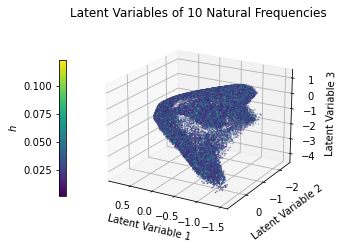

In [53]:
propnum = 8
plot_labels = [r'$\nu$', r'$a/b$', r'$a/h$', r'$b/h$', r'$Q_2$', r'$Q_3$', r'$Q_4$', r'$c_1/a$', r'$c_1/b$']

data = pd.read_csv('Data Workspace\FS_TV.csv')

%matplotlib inline
plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')
scatter = ax.scatter(predictZ[:,0].to('cpu'),predictZ[:,1].to('cpu'),predictZ[:,2].to('cpu'),
 c = data['h'], marker='.', s=1)

plt.title('Latent Variables of 10 Natural Frequencies')
ax.set_xlabel('Latent Variable 1')
ax.set_ylabel('Latent Variable 2')
ax.set_zlabel('Latent Variable 3')
plt.colorbar(scatter, shrink=0.5, location='left', label=r'$h$')
ax.view_init(azim=120, elev=20)
plt.savefig('Latent_Space_h.pdf', dpi=1200, bbox_inches='tight')
plt.show()


In [ ]:
%matplotlib inline
propnum = 1
plt.figure(figsize=(4,4))
plt.scatter(predictZ[:,0].to('cpu'),Y[:,propnum].to('cpu'),  marker='.', s=1)
plt.show()

plt.figure(figsize=(4,4))
plt.scatter(predictZ[:,1].to('cpu'),Y[:,propnum].to('cpu'),  marker='.', s=1)
plt.show()

plt.figure(figsize=(4,4))
plt.scatter(predictZ[:,2].to('cpu'),Y[:,propnum].to('cpu'),  marker='.', s=1)
plt.show()

# plt.figure(figsize=(4,4))
# plt.scatter(predictZ[:,3].to('cpu'),Y[:,propnum].to('cpu'),  marker='.')
# plt.show()